In [1]:
import pennylane as qml
from pennylane import numpy as np
import qiskit
import sys
import matplotlib.pyplot as plt

The history saving thread hit an unexpected error (DatabaseError('database disk image is malformed')).History will not be written to the database.


## Problem description
- Implement a circuit that returns $|01\rangle$ and $|10\rangle$ with equal probability.
- Use only `CNOT`, `RX`, and `RY`.
- Find parameters with gradient descent.
- Simulations must be done with sampling and noise.

### Intuition
The circuit that returns $|00\rangle$ and $|10\rangle$ with equal probability is one that generates a state vector of the form

\begin{equation}
|\Phi\rangle = e^{i \theta} \frac{1}{\sqrt{2}} [|01\rangle + e^{i \phi}|10\rangle].
\end{equation}

The global phase, $e^{i \theta}$, is physically irrelevant. The relative phase $e^{i \phi}$ will not effect the probabilities of measurement outcomes on this state, but different relative phase factors correspond to quantum states which *are* physically different.
<br><br><br>
To keep it simple, let's consider the state 
\begin{equation}
|\Psi\rangle = \frac{1}{\sqrt{2}} [|01\rangle + |10\rangle].
\end{equation}

**What is the non-parametric circuit that generates this state vector?**

Well, $|\psi\rangle$ looks kind of like the simplest Bell state $|\beta_{00}\rangle = \frac{1}{\sqrt{2}} [|00\rangle + |11\rangle]$, in fact $|\Psi\rangle$ is itself a Bell state. The state, $|\beta_{00}\rangle$, says that qubit one and qubit two will be in the same compuational basis state upon measurement. We want the opposite of that: if one qubit is in the $|0\rangle$ state, the other ought to be in the $|1\rangle$ state, and vice versa. Since, we want to flip the results, it sounds like we might need an `X` gate.
<br><br>
This intuition proves correct, as a simple way to implement the circuit that acheives our goals is to modify the familiar circuit for $|\beta_{00}\rangle$ by inserting an additional `X` gate on the second qubit.

In [2]:
qc = qiskit.QuantumCircuit(2)
qc.h(0)
qc.x(1)
qc.cx(0, 1)
# qc.x(1) # alternative X-gate position

backend = qiskit.Aer.get_backend("statevector_simulator")
psi = qiskit.execute(qc, backend).result().get_counts()

print(qc)
print(psi)

     ┌───┐     
q_0: ┤ H ├──■──
     ├───┤┌─┴─┐
q_1: ┤ X ├┤ X ├
     └───┘└───┘
{'01': 0.5, '10': 0.5}


**Now with our gate set**

Our gate set is {`CNOT`, `RX`, `RY`}. So what is a corresponding parameteric circuit?

Well, if we try to match gates from the circuit above to our gate set, obviously we have `CNOT`. Further, $RY(\frac{\pi}{2}) = H$. 

We can't exactly get the `X` with any paramaterization of a single `RX` or `RY`. However, we can get the same effect on the $|0\rangle$ state as 
\begin{equation}
RY(\pi)|0\rangle = |1\rangle, \\
RX(\pi)|0\rangle = |1\rangle.
\end{equation}

I'll choose to use `RY`. This way, we keep the coefficients of our state vector purely real. 

In [3]:
qc = qiskit.QuantumCircuit(2)
qc.ry(np.pi/2, 0)
qc.ry(np.pi, 1)
qc.cx(0, 1)

backend = qiskit.Aer.get_backend("statevector_simulator")
psi = qiskit.execute(qc, backend).result().get_counts()

print(qc)
print(psi)

     ┌──────────┐     
q_0: ┤ RY(pi/2) ├──■──
     └┬────────┬┘┌─┴─┐
q_1: ─┤ RY(pi) ├─┤ X ├
      └────────┘ └───┘
{'01': 0.5, '10': 0.5}


### Some analytic calculations
We've proven that the circuit above is expressive enough to generate the state $|\Psi\rangle$.

We can represent our parameterized circuit as

\begin{equation}
CX_{0,1}RY_1(\theta_1)RY_0(\theta_0)|00\rangle = |\psi\rangle.
\end{equation}

With arbitrary prametizeration, doing the matrix calculations gives us

\begin{equation}
|\psi\rangle = cos(\theta_0)cos(\theta_1)|00\rangle + cos(\theta_0)sin(\theta_1)|01\rangle + sin(\theta_0)sin(\theta_1)|10\rangle + sin(\theta_0)cos(\theta_1)|11\rangle.
\end{equation}
<br><br>
**How do we know if our circuit gives a good answer?**

Since the problem requires that we sample we'll only have access the counts, and from the counts we can compute the probabilities of various measurement results. 

We know the desired probabilities -- in vector form they are $$ \vec{y} = [0, 0.5, 0.5, 0]^T.$$

The vector of probabilites given by $|\psi\rangle$ is 

\begin{equation}
\vec{p} = [|cos(\theta_0)cos(\theta_1)|^2, |cos(\theta_0)sin(\theta_1)|^2, |sin(\theta_0)sin(\theta_1)|^2, |sin(\theta_0)cos(\theta_1)|^2].
\end{equation}

But, we can simplify a bit. Notice that our coefficients are all real. For any $x \in \mathbb{R}$, we have $|x| = \sqrt{x^2}$. With this identity we can simplify our probability vector,

\begin{equation}
\vec{p} = [(cos(\theta_0)cos(\theta_1))^2, (cos(\theta_0)sin(\theta_1))^2, (sin(\theta_0)sin(\theta_1))^2, (sin(\theta_0)cos(\theta_1))^2].
\end{equation}

**Loss function**

With, $\vec{y}$ and $\vec{p}$ we can construct a Mean Squared Error loss function, $\mathcal{L}$.

\begin{equation}
\mathcal{L} = \sum_i = (\vec{p}_i - \vec{y}_i)^2
\end{equation}

In [4]:
y = np.array([0, 0.5, 0.5, 0])

dev = qml.device('default.qubit', wires=2, shots=1000, analytic=False)

@qml.qnode(dev)
def circuit(theta_vector):
    qml.RY(theta_vector[0], wires=0)
    qml.CNOT(wires=[0,1])
    qml.RY(theta_vector[1], wires=1)
    return qml.probs([0, 1])

def loss(theta_vector):
    p = circuit(theta_vector)
    return np.sum((p - y)**2)

**The gradients and the update rule**

To know how to update the parameters $\theta_0$ and $\theta_1$, we need to take the gradient of the loss function with respect to the parameters. 

\begin{equation}
\nabla \mathcal{L} = [\frac{\mathcal{L}}{\theta_0}, \frac{\mathcal{L}}{\theta_1}]^T
\end{equation}

In our case, we can see that that $\frac{\mathcal{L}}{\theta_0}$ and $\frac{\mathcal{L}}{\theta_1}$ are simply going to be scalar values composed of the sum of terms which are various products of cosine and sine. 

The update rule is
\begin{equation}
\vec{\theta}^{(t+1)} = \vec{\theta}^{(t)} - \alpha \nabla \mathcal{L}.
\end{equation}



## Implementation
We can now combine our circuit ansatz, the loss function, and our gradient/update rule to solve our problem using PennyLane. Given, our above formulation, we could compute the gradients and update our parameters totally analyitically, but using the functionality of PennyLane demonstrates a more general (and easier) approach. 

In [5]:
opt = qml.GradientDescentOptimizer(stepsize=0.4)

# set the number of steps
steps = 100
# set the initial parameter values
params = [0, 0]

for i in range(steps):
    # update the circuit parameters
    params = opt.step(loss, params)

    if (i + 1) % 5 == 0:
        print("Cost after step {:5d}: {: .7f}".format(i + 1, loss(params)))

print("Optimized rotation angles: {}".format(params))

Cost after step     5:  1.4940080
Cost after step    10:  0.7013360
Cost after step    15:  0.3609000
Cost after step    20:  0.2153660
Cost after step    25:  0.0449700
Cost after step    30:  0.0106760
Cost after step    35:  0.0056540
Cost after step    40:  0.0029300
Cost after step    45:  0.0025800
Cost after step    50:  0.0010140
Cost after step    55:  0.0016140
Cost after step    60:  0.0011260
Cost after step    65:  0.0004540
Cost after step    70:  0.0008520
Cost after step    75:  0.0007260
Cost after step    80:  0.0009780
Cost after step    85:  0.0011240
Cost after step    90:  0.0004420
Cost after step    95:  0.0001740
Cost after step   100:  0.0003460
Optimized rotation angles: [1.5822876000000003, 2.890970799999999]


## Analysis

Let's analyze the cost for different numbers of samples. We can see that as we increase the number of samples, the loss function decreases much more smoothly.

In [6]:
def circuit(theta_vector):
    qml.RY(theta_vector[0], wires=0)
    qml.CNOT(wires=[0,1])
    qml.RY(theta_vector[1], wires=1)
    return qml.probs([0, 1])

def loss(theta_vector):
    p = device_circuit(theta_vector)
    return np.sum((p - y)**2)

def device_optimizer():
    opt = qml.GradientDescentOptimizer(stepsize=0.4)

    # set the number of steps
    steps = 100
    # set the initial parameter values
    params = [0, 0]
    
    losses = []
    for i in range(steps):
        # update the circuit parameters
        params = opt.step(loss, params)
        
        losses.append(loss(params))

    return params, losses

In [7]:
n_shots_list = [1, 10, 100, 1000]
param_list = []
loss_list = []

for n_shots in n_shots_list:
    device = qml.device('default.qubit', wires=2, shots=n_shots, analytic=False)

    device_circuit = qml.QNode(circuit, device)
    
    parms, losses = device_optimizer()
    param_list.append(parms)
    loss_list.append(losses)

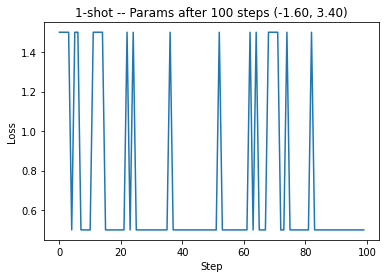

In [8]:
plt.plot(loss_list[0])
plt.ylabel("Loss")
plt.xlabel("Step")
plt.title("1-shot -- Params after 100 steps ({:.2f}, {:.2f})".format(param_list[0][0], param_list[0][1]))
plt.show()

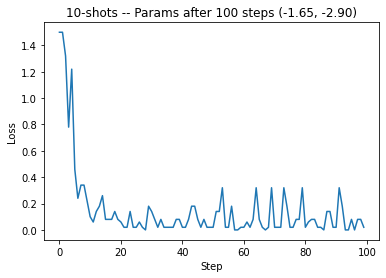

In [9]:
plt.plot(loss_list[1])
plt.ylabel("Loss")
plt.xlabel("Step")
plt.title("10-shots -- Params after 100 steps ({:.2f}, {:.2f})".format(param_list[1][0], param_list[1][1]))
plt.show()

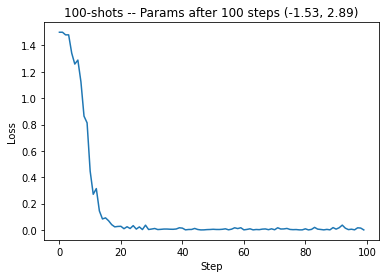

In [10]:
plt.plot(loss_list[2])
plt.ylabel("Loss")
plt.xlabel("Step")
plt.title("100-shots -- Params after 100 steps ({:.2f}, {:.2f})".format(param_list[2][0], param_list[2][1]))
plt.show()

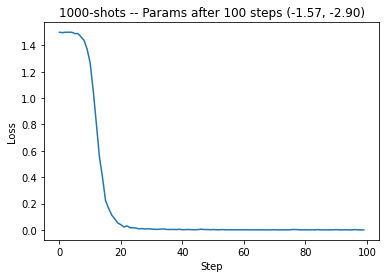

In [11]:
plt.plot(loss_list[3])
plt.ylabel("Loss")
plt.xlabel("Step")
plt.title("1000-shots -- Params after 100 steps ({:.2f}, {:.2f})".format(param_list[3][0], param_list[3][1]))
plt.show()